In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import (
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
    Lambda,
)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
data_dir = "./data/train/"
labels_path = "./data/labels.csv"
img_size = (224, 224, 3)

In [5]:
df = pd.read_csv(labels_path)
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
df["image_path"] = data_dir + df["id"] + ".jpg"
df = df.drop(columns="id")

In [7]:
breeds = sorted(df["breed"].unique().tolist())
len(breeds)

120

In [8]:
class_to_num = dict(zip(breeds, range(len(breeds))))

<h1> Using Machine Learning

In [9]:
ml_labels = df["breed"]
ml_data_list = []

In [10]:
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    img_pixels = load_img(row["image_path"], target_size=(32, 32, 3))
    img_pixels = img_to_array(img_pixels)
    img_pixels = img_pixels.ravel().reshape(1, -1)

    row_data = pd.DataFrame(
        img_pixels, columns=[f"pixel{i}" for i in range(len(img_pixels[0]))]
    )
    ml_data_list.append(row_data)

100%|██████████| 10222/10222 [01:43<00:00, 98.29it/s] 


In [11]:
ml_data = pd.concat(ml_data_list, ignore_index=True)

In [12]:
ml_train_data, ml_test_data, ml_train_label, ml_test_label = train_test_split(
    ml_data.to_numpy(), ml_labels.to_numpy(), test_size=0.2
)

In [13]:
ml_test_data.shape

(2045, 3072)

In [14]:
ml_train_data.shape

(8177, 3072)

In [15]:
rdc = RandomForestClassifier(n_estimators=100, random_state=42)
rdc.fit(ml_train_data, ml_train_label)

RandomForestClassifier(random_state=42)

In [16]:
lg = LogisticRegression()
lg.fit(ml_train_data, ml_train_label)

LogisticRegression()

In [17]:
lg_pred = lg.predict(ml_test_data)

In [18]:
rdc_pred = rdc.predict(ml_test_data)

In [19]:
def evaluation_performance(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(
        y_true, y_pred, pos_label="positive", average="micro"
    )
    rec = recall_score(y_true, y_pred, pos_label="positive", average="micro")
    return {"Accuracy: ": acc, "Precision: ": pre, "Recall: ": rec}

In [20]:
evaluation_performance(ml_test_label, lg_pred)

{'Accuracy: ': 0.03569682151589242,
 'Precision: ': 0.03569682151589242,
 'Recall: ': 0.03569682151589242}

In [21]:
evaluation_performance(ml_test_label, rdc_pred)

{'Accuracy: ': 0.044009779951100246,
 'Precision: ': 0.044009779951100246,
 'Recall: ': 0.044009779951100246}

<h1>Using CNN

Put all images into 1 array n value [n, x1, x2, x3]: <br>
n: number of images<br>
x1: height of image<br>
x2: width of image<br>
x3: depth of image(1 for grayscale image, 3 for color image)


In [22]:
def image_processing(data: pd.DataFrame, image_size: tuple):
    X = np.zeros(
        [len(data), image_size[0], image_size[1], image_size[2]],
        dtype=np.uint8,
    )
    y = np.zeros([len(data), 1], dtype=np.uint8)
    for idx, row in tqdm(data.iterrows(), total=data.shape[0]):
        img_pixels = load_img(row["image_path"], target_size=image_size)
        X[idx] = img_pixels
        y[idx] = class_to_num[row["breed"]]
    return X, y

In [23]:
X, y = image_processing(df, img_size)

100%|██████████| 10222/10222 [00:10<00:00, 978.75it/s]


In [24]:
X.shape

(10222, 224, 224, 3)

Extract feature using MobileNetV2

In [25]:
def extract_feature(image_size: tuple, data):
    input_layer = Input(image_size)
    processor = Lambda(preprocess_input)(input_layer)
    base_model = MobileNetV2(
        weights="imagenet", include_top=False, input_shape=image_size
    )(processor)
    maxPool = MaxPooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=maxPool)
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    return feature_maps

In [26]:
features = extract_feature(img_size, X)

160/160 [==============================] - 76s 467ms/step


In [27]:
features.shape

(10222, 3, 3, 1280)

In [28]:
le = LabelBinarizer()
y = le.fit_transform(y)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(
    features, y, test_size=0.2, random_state=12
)

In [30]:
X_train = X_train / 255.0
X_val = X_val / 255.0

In [31]:
X_train.shape[1:]

(3, 3, 1280)

Using Neural Network

In [32]:
model = Sequential()
model.add(Input(X_train.shape[1:]))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))

model.add(Dense(len(breeds), activation="softmax"))
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 256)               2949376   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 120)               15480     
                                                                 
Total params: 2,997,752
Trainable params: 2,997,752
Non-trainable params: 0
_________________________________________________________________


In [33]:
epochs = 20
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=64,
)

Epoch 1/20
128/128 [==============================] - 2s 10ms/step - loss: 3.7339 - accuracy: 0.2238 - val_loss: 2.0645 - val_accuracy: 0.4934
Epoch 2/20
128/128 [==============================] - 1s 9ms/step - loss: 1.5541 - accuracy: 0.5825 - val_loss: 1.2143 - val_accuracy: 0.6557
Epoch 3/20
128/128 [==============================] - 1s 9ms/step - loss: 1.0689 - accuracy: 0.6841 - val_loss: 1.0126 - val_accuracy: 0.7144
Epoch 4/20
128/128 [==============================] - 1s 9ms/step - loss: 0.8269 - accuracy: 0.7568 - val_loss: 0.9411 - val_accuracy: 0.7257
Epoch 5/20
128/128 [==============================] - 1s 9ms/step - loss: 0.6765 - accuracy: 0.7989 - val_loss: 0.8888 - val_accuracy: 0.7408
Epoch 6/20
128/128 [==============================] - 1s 9ms/step - loss: 0.5581 - accuracy: 0.8305 - val_loss: 0.8802 - val_accuracy: 0.7457
Epoch 7/20
128/128 [==============================] - 1s 9ms/step - loss: 0.4596 - accuracy: 0.8639 - val_loss: 0.8298 - val_accuracy: 0.7438
Epoch

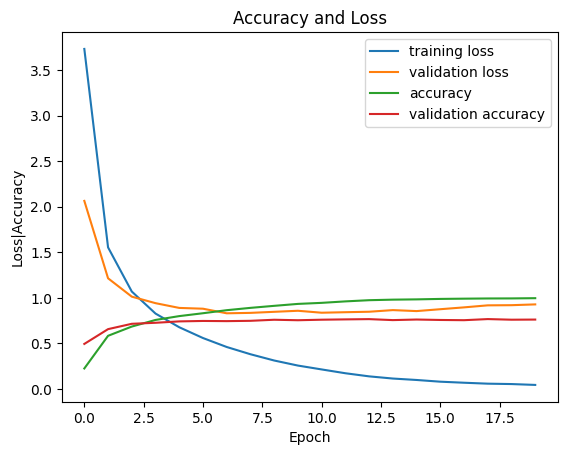

In [34]:
fig = plt.figure()
plt.plot(
    np.arange(0, epochs), history.history["loss"], label="training loss"
)
plt.plot(
    np.arange(0, epochs),
    history.history["val_loss"],
    label="validation loss",
)
plt.plot(
    np.arange(0, epochs), history.history["accuracy"], label="accuracy"
)
plt.plot(
    np.arange(0, epochs),
    history.history["val_accuracy"],
    label="validation accuracy",
)
plt.title("Accuracy and Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss|Accuracy")
plt.legend()

In [35]:
test_path = "./data/test/"
img_test_files = os.listdir(test_path)[:15]

1/1 [==============================] - 0s 14ms/step


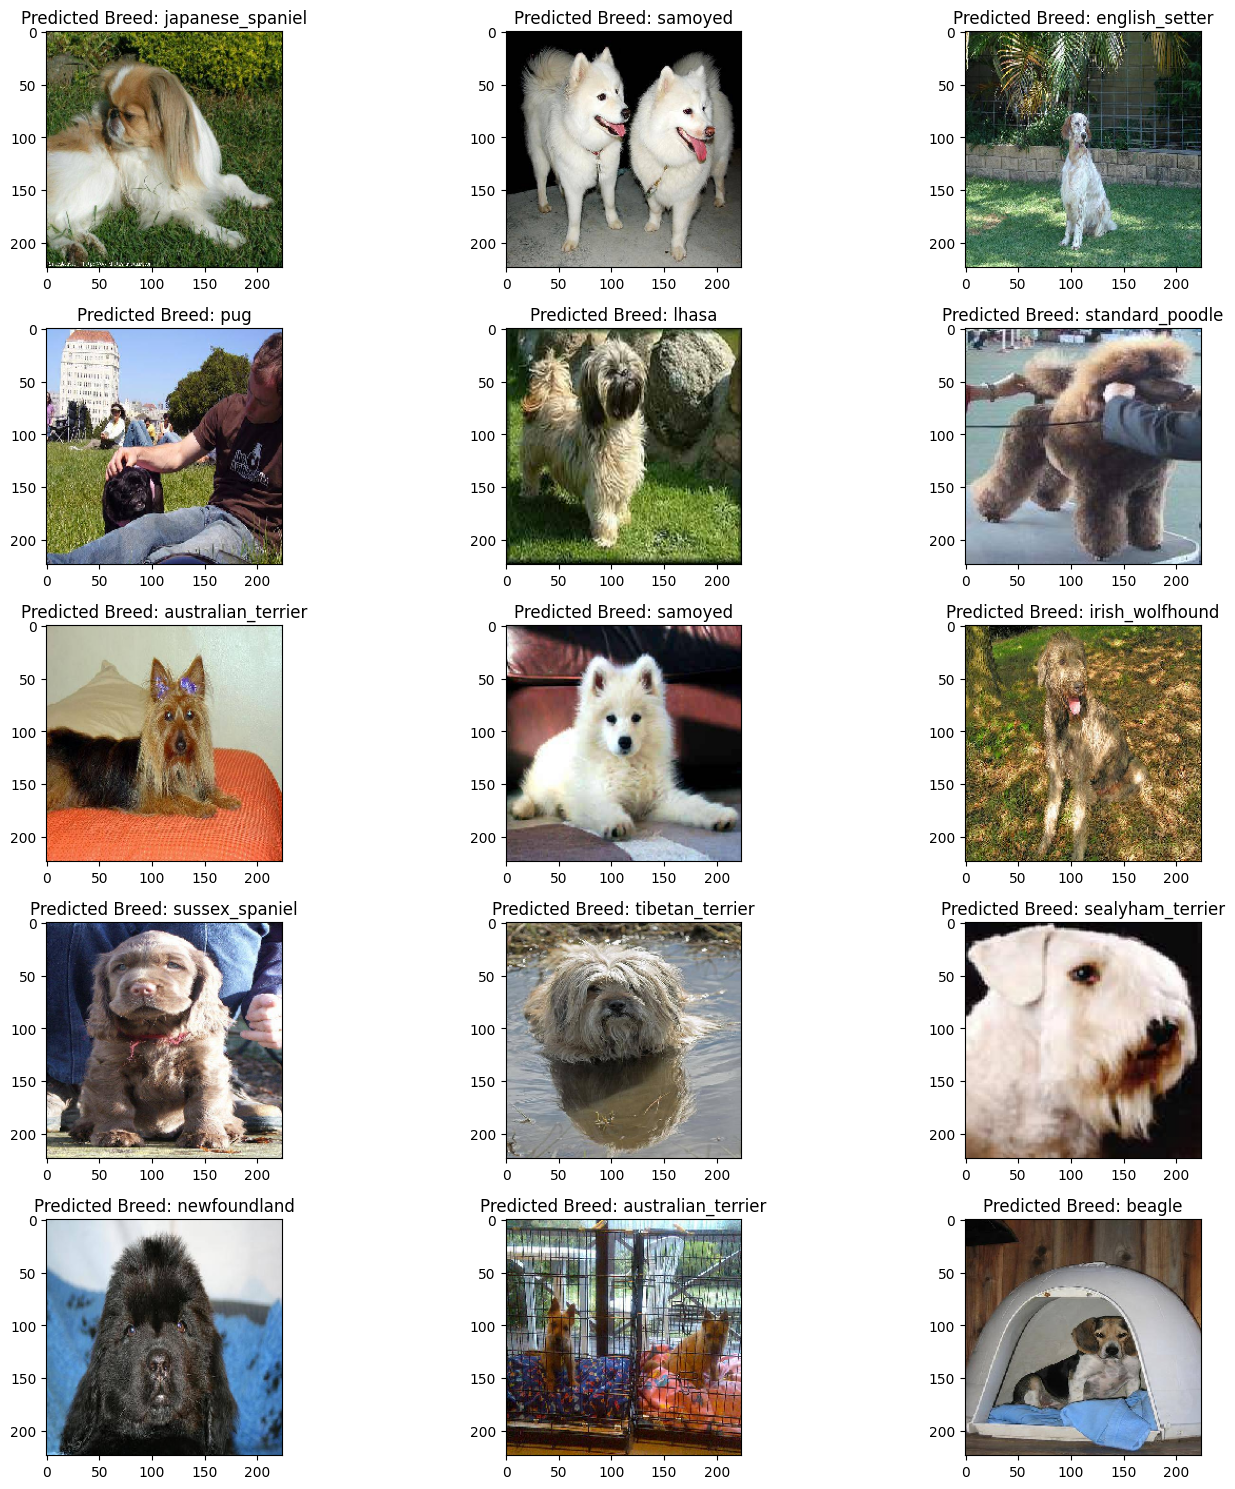

In [36]:
num_cols = 3
num_rows = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, img in enumerate(img_test_files):
    file_name = os.path.join(test_path, img)
    image_test = load_img(file_name, target_size=img_size)
    img_array = np.array(image_test)
    img_array = img_array.reshape((1, 224, 224, 3))
    img_array = extract_feature(img_size, img_array)
    breed_index = model.predict(img_array).argmax(axis=-1)
    breed_label = [
        label for label, index in class_to_num.items() if index == breed_index
    ][0]

    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(image_test)
    axes[row, col].set_title(f"Predicted Breed: {breed_label}")

plt.tight_layout()
plt.show()

In [37]:
model.save("./model/dog_classifier.keras")